In [41]:
from SOH_func import *
import matplotlib.pyplot as pl
from tensorflow import summary as sm
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
VERSION = 'Current'

FILE_00 = 'CYCLE_CSV_data.csv'
FILE_01 = 'CYCLE_CSV_data01.csv'
FILE_02 = 'CYCLE_CSV_data02.csv'

drop_labels_x = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']

param = {'seq_len' : 20, 'num_units' : 64, 'num_filters' : 64, 'window' : 3, 'num_epochs' : 5000}

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\SOH_{VERSION}_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ\{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'
hist_freq = 80

save_path = f'output\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')

Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data00 = (481, 2)
[0.04249983 0.04255564 0.04258386 0.04265123 0.04271386 0.04275012]
[0.04249983 0.04255564 0.04258386 0.04265123 0.04271386 0.04275012]


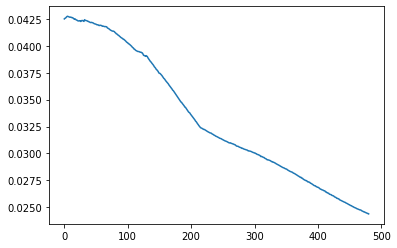

data01 = (481, 2)


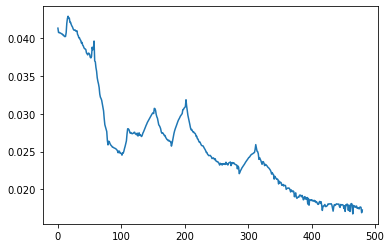

data_test = (481, 2)


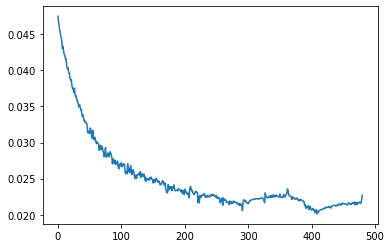

In [53]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_02, drop_labels_x, drop_labels_y)
data00 = data00[29:]
data_cap00 = data_cap00[29:]
data01 = data01[69:]
data_cap01 = data_cap01[69:]
data_test = data_test[69:]
data_cap_test = data_cap_test[69:]

print(f'data00 = {data00.shape}')
pl.plot(data_cap00)
pl.show()
print(f'data01 = {data01.shape}')
pl.plot(data_cap01)
pl.show()
print(f'data_test = {data_test.shape}')
pl.plot(data_cap_test)
pl.show()

In [60]:
x_train00, y_train00, num_batch00  = seq_gen(data00, data_cap00, param['seq_len'])
x_train01, y_train01, num_batch01  = seq_gen(data01, data_cap01, param['seq_len'])
x_test, y_test, num_batch_test  = seq_gen(data_test, data_cap_test, param['seq_len'])
print(f'num_batch = {num_batch00}')
print(x_train00.shape)
print(y_train00.shape)
print(x_train00[0, 0:6, 0])
print(y_train00[0, :6])

num_batch = 24
x = (24, 20, 2)
y = (24, 20, 1)
num_batch = 24
x = (24, 20, 2)
y = (24, 20, 1)
num_batch = 24
x = (24, 20, 2)
y = (24, 20, 1)
num_batch = 24
(24, 20, 2)
(24, 20, 1)
[0.04249983 0.04255564 0.04258386 0.04265123 0.04271386 0.04275012]
[[0.04255564]
 [0.04258386]
 [0.04265123]
 [0.04271386]
 [0.04275012]
 [0.04272761]]


In [45]:
model = models.Sequential()
model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
model.add(layers.LSTM(param['num_units'], return_sequences = True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 64)          448       
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          33024     
                                                                 
 time_distributed_4 (TimeDis  (None, None, 1)          65        
 tributed)                                                       
                                                                 
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
_________________________________________________________________


In [46]:
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 2, validation_split = 0.3, callbacks=callback_list)

Epoch 1/5000
1/1 - 1s - loss: 0.0014 - val_loss: 1.0583e-04 - 1s/epoch - 1s/step
Epoch 2/5000
1/1 - 0s - loss: 3.3992e-04 - val_loss: 1.2118e-04 - 28ms/epoch - 28ms/step
Epoch 3/5000
1/1 - 0s - loss: 9.6666e-05 - val_loss: 4.8566e-04 - 30ms/epoch - 30ms/step
Epoch 4/5000
1/1 - 0s - loss: 3.4333e-04 - val_loss: 6.5178e-04 - 30ms/epoch - 30ms/step
Epoch 5/5000
1/1 - 0s - loss: 4.8243e-04 - val_loss: 5.4627e-04 - 35ms/epoch - 35ms/step
Epoch 6/5000
1/1 - 0s - loss: 3.8932e-04 - val_loss: 3.3919e-04 - 26ms/epoch - 26ms/step
Epoch 7/5000
1/1 - 0s - loss: 2.2016e-04 - val_loss: 1.5974e-04 - 21ms/epoch - 21ms/step
Epoch 8/5000
1/1 - 0s - loss: 9.7675e-05 - val_loss: 5.6685e-05 - 37ms/epoch - 37ms/step
Epoch 9/5000
1/1 - 0s - loss: 6.0829e-05 - val_loss: 2.2510e-05 - 38ms/epoch - 38ms/step
Epoch 10/5000
1/1 - 0s - loss: 8.9431e-05 - val_loss: 2.5134e-05 - 24ms/epoch - 24ms/step
Epoch 11/5000
1/1 - 0s - loss: 1.3961e-04 - val_loss: 3.3753e-05 - 25ms/epoch - 25ms/step
Epoch 12/5000
1/1 - 0s - lo

In [47]:
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 2, validation_split = 0.3, callbacks=callback_list)

Epoch 1/5000
1/1 - 0s - loss: 2.8035e-06 - val_loss: 2.1072e-05 - 83ms/epoch - 83ms/step
Epoch 2/5000
1/1 - 0s - loss: 1.3274e-05 - val_loss: 6.4516e-06 - 39ms/epoch - 39ms/step
Epoch 3/5000
1/1 - 0s - loss: 1.3933e-05 - val_loss: 4.6991e-06 - 36ms/epoch - 36ms/step
Epoch 4/5000
1/1 - 0s - loss: 2.5148e-06 - val_loss: 4.1905e-06 - 36ms/epoch - 36ms/step
Epoch 5/5000
1/1 - 0s - loss: 2.9495e-06 - val_loss: 7.1548e-06 - 22ms/epoch - 22ms/step
Epoch 6/5000
1/1 - 0s - loss: 8.3266e-06 - val_loss: 1.1035e-06 - 38ms/epoch - 38ms/step
Epoch 7/5000
1/1 - 0s - loss: 1.3449e-06 - val_loss: 1.9072e-06 - 22ms/epoch - 22ms/step
Epoch 8/5000
1/1 - 0s - loss: 3.2506e-06 - val_loss: 7.3381e-06 - 23ms/epoch - 23ms/step
Epoch 9/5000
1/1 - 0s - loss: 4.5992e-06 - val_loss: 1.5969e-06 - 23ms/epoch - 23ms/step
Epoch 10/5000
1/1 - 0s - loss: 5.1896e-07 - val_loss: 1.3298e-06 - 24ms/epoch - 24ms/step
Epoch 11/5000
1/1 - 0s - loss: 4.2539e-06 - val_loss: 3.2704e-06 - 23ms/epoch - 23ms/step
Epoch 12/5000
1/1 -

1/1 [==============================] - 0s 194ms/step
(480, 1) (480, 1)
{'output\\64FL-64UN-5000EP-20SQ'}


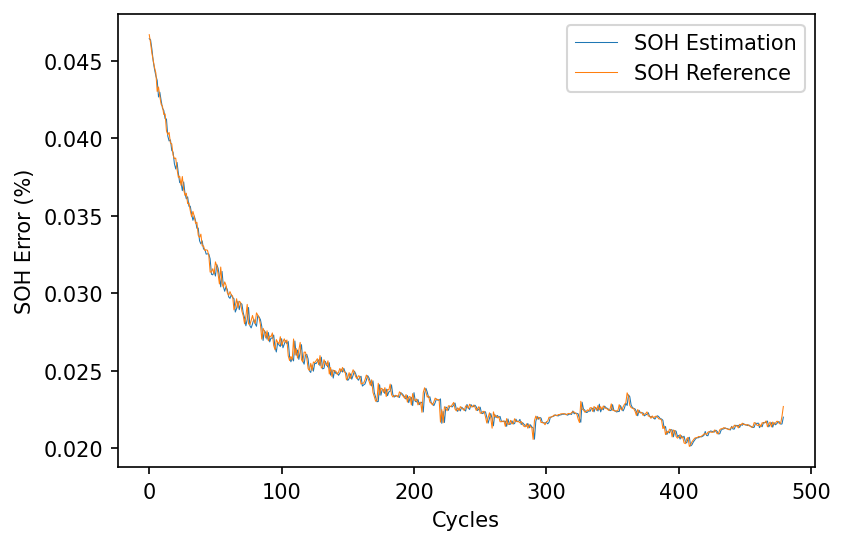

In [48]:
RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)

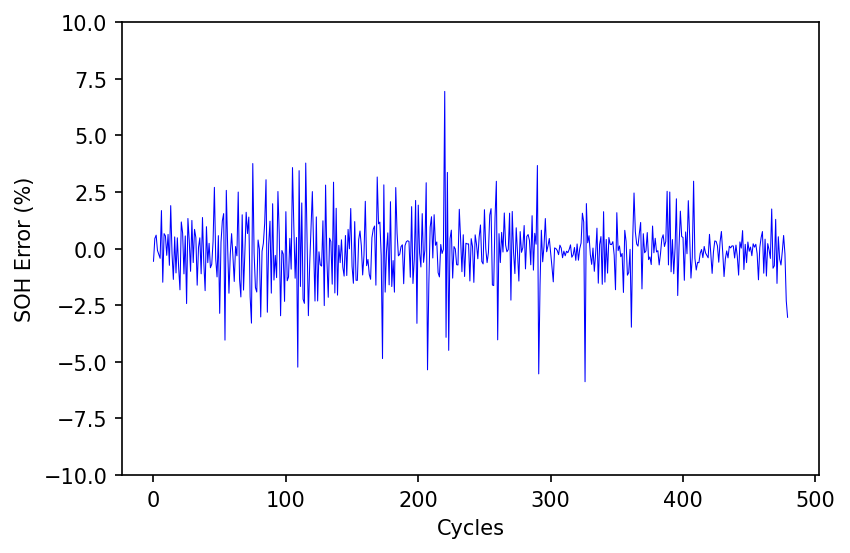

RMSE(0.0143), MAE(0.0101)


In [49]:
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOH Error (%)')
pl.xlabel('Cycles')
pl.setp(line, color='b', linewidth=0.5)
pl.savefig(f'{save_path}\\ErrRate-RMSE({RMSE:.4f})MAE({MAE:.4f}).png')
pl.show()
print(f'RMSE({RMSE:.4f}), MAE({MAE:.4f})')